# CGQeMCMC Tutorial

Here we assume you have set up your python environment, with the latest version of cgqemcmc (0.3.3 at time of writing) and the required packages in requirements,txt

## Import packages

In [15]:
from cgqemcmc.basic_utils import *
from cgqemcmc.qulacs_CGQeMCMC import MCMC_qulacs
from cgqemcmc.classical_mcmc_routines import MCMC_Classical

from cgqemcmc.Model_Maker import Model_Maker
import numpy as np

In [16]:
# Define parameters
n_spins = 9 # Number of spins in the system
reps = 10 # How many markov chains to produce
n_hops = 100 # Length of each markov chain
temp = 0.3 # Temperature of the system


# CGQeMCMC parameters
gamma = (0.3,0.6)# Relative strength of mixer hamiltonian 
time = (1,10) # Time for hamiltonian simulation

# Number of qubits to use in each partitioned lattice.
# Set as sqrt(n_spins) groups of size sqrt(n_spins)
sample_sizes = [int(np.sqrt(n_spins)),]*int(np.sqrt(n_spins)) 


In [17]:
# Initialise your random fully connected Ising model
MK = Model_Maker(n_spins, "Fully Connected Ising", str(n_spins), cost_function_signs = [-1,-1])
model = MK.model


In [18]:
# Run Markov chains for local proposal
localchains = []
for r in range(reps):
    MCMC = MCMC_Classical(model, temp, method = "local")
    output = MCMC.run(n_hops, initial_state=model.initial_state[r], sample_frequency=1)
    localchains.append(output)

In [19]:
# Run Markov chains for Coarse grained quantum proposal
CG_chains = []
for r in range(reps):
    MCMC = MCMC_qulacs(model, gamma, time, temp, sample_sizes=sample_sizes)
    output = MCMC.run(n_hops, initial_state=model.initial_state[r], sample_frequency=1)
    CG_chains.append(output)

## Analysis

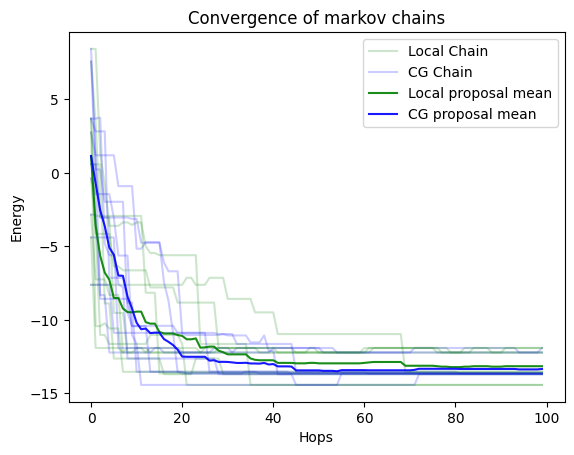

In [20]:
# Plot energies of all chains
local_energies = np.zeros((reps,n_hops))
CG_energies = np.zeros((reps,n_hops))
for r in range(reps):
    
    localchains[r].get_accepted_energies()
    plt.plot(localchains[r].accepted_positions , localchains[r].accepted_energies, color = "green",alpha = 0.2, label = "Local Chain")

    CG_chains[r].get_accepted_energies()
    plt.plot(CG_chains[r].accepted_positions , CG_chains[r].accepted_energies, color = "blue",alpha = 0.2, label = "CG Chain")
    
    
    local_energies[r,:] = localchains[r].accepted_energies
    CG_energies[r,:] = CG_chains[r].accepted_energies
    
mean_CG_energies = np.mean(CG_energies, axis = 0)
mean_local_energies = np.mean(local_energies, axis = 0)

plt.title("Convergence of markov chains")
plt.xlabel("Hops")
plt.ylabel("Energy")


plt.plot(localchains[0].accepted_positions, mean_local_energies, color = "green",  alpha = 0.9,label = "Local proposal mean")
plt.plot(CG_chains[0].accepted_positions, mean_CG_energies, color = "blue", alpha = 0.9,  label = "CG proposal mean")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

## Convergence
Hopefully it should be clear that fewer of the CG-Quantum chains get stuck in local minima, and are able to fully traverse the state space. This results in the average energy across multiple chains reaching the stationary distribution earlier than the classical local proposal. Of course, chains may look like they have thermalised, however they are actually stuck in non-global minima.

## Temperature dependence

Naturally, we expect the CGQeMCMC to be much more effective at lower temperatures so changing the initial temperature should result in different outcomes. Have a play with the temperature parameter and see how it affects convergence. For low temperatures T<0.1, classical chains are highly likely to get stuck in local minima and only converge to the stationary distribution extremely slowly.

## Size dependence

The difficulty of the sampling problem is exponentially related to the size of the Ising model. Play with the size of the system and see how the problem becomes difficult. Also change the number of qubits used and see how the quantum method improves with more qubits. Bear in mind that more qubits will be harder to simulate on your laptop!

## Random nature of MCMC

Please note that to gain a true insight into the efficacy of these methods, one needs to average over many different chains, on many different model instances. Some model instances are naturally much harder and some random starting positions are lucky - they are close to the global minima. This means that the simple experiment above may give unreliable results, but if you run it enough times, a clear trend should be clear.